# cosine schedule - with tinyai

In [ ]:
! git clone https://github.com/GalaxUniv/tinyai.git
! pip install tinyai/.
! pip uninstall torchaudio -y

In [ ]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *
from tinyai.accel import *

In [ ]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512
dsd = load_dataset(name)

Also in this notebook we will change our abar function from:
```python
def abar(t, T): return (t/T*math.pi/2).cos()**2
```
to this one

In [ ]:
def abar(t): return (t*math.pi/2).cos()**2

In this function we use only one variable `t`, which has values in the range (0,1)

In [ ]:
def inv_abar(x): return x.sqrt().acos()*2/math.pi

In [ ]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999) # here we clamp the values
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

dl = dls.train
(xt,t),eps = b = next(iter(dl))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


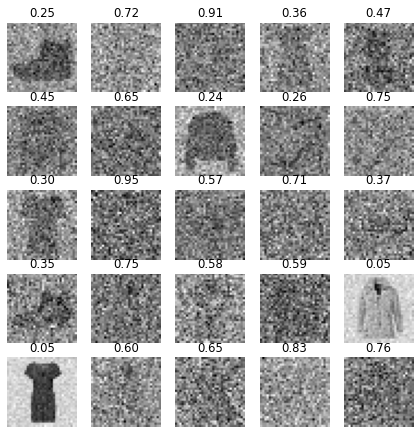

In [ ]:
show_images(xt[:25], imsize=1.5, titles=fc.map_ex(t[:25], '{:.02f}'))

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
lr = 4e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8).to('cuda')
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.401,0,train
0.070,0,eval
0.058,1,train
0.052,1,eval
0.049,2,train
0.047,2,eval
0.046,3,train
0.045,3,eval
0.043,4,train
0.043,4,eval


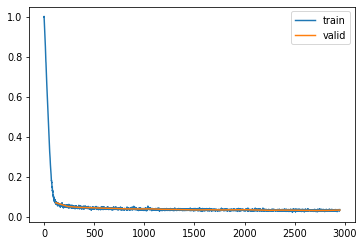

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/fashion_cos.pkl')
# model = learn.model = torch.load('models/fashion_cos.pkl').cuda()

In [ ]:
def denoise(x_t, noise, t):
    device = x_t.device
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    return ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt()).clamp(-1,1)

In [ ]:
with torch.no_grad(): noise=learn.model((xt.cuda(),t.cuda()))

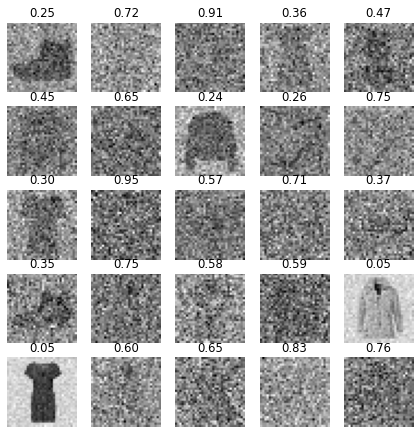

In [ ]:
show_images(xt[:25], imsize=1.5, titles=fc.map_ex(t[:25], '{:.02f}'))

We are removing the added noise at the timestep. The higher the value the more noise there is

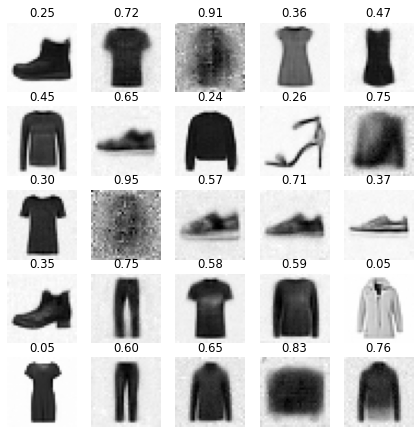

In [ ]:
show_images(denoise(xt.cuda(),noise,t.cuda())[:25].clamp(-1,1), imsize=1.5, titles=fc.map_ex(t[:25], '{:.02f}'))

## Sampling

In [ ]:
from tinyai.fid import ImageEval

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cmodel = torch.load('drive/MyDrive/models/tinyai/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [ ]:
sz = (2048,1,32,32)

In [ ]:
sz = (256,1,32,32)

In [ ]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt()).clamp(-1.5,1.5)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [ ]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1.):
    # Here we just use linspace insted of range
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(progress_bar(ts)):
        abar_t = abar(t)
        noise = model((x_t, t))
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
#         print(abar_t,abar_t1,x_t.min(),x_t.max())
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100))
        preds.append(x_0_hat.float().cpu())
    return preds

In [ ]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)
s.min(),s.max(),s.shape

(tensor(-1.1494), tensor(1.5697), torch.Size([256, 1, 32, 32]))

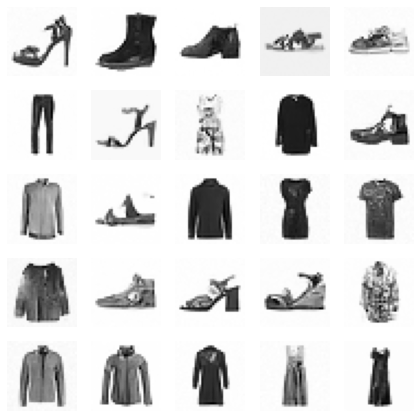

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s),ie.kid(s),s.shape

(13.3953857421875, 0.054553668946027756, torch.Size([256, 1, 32, 32]))

In [ ]:
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
ie.fid(preds[-1]*2)

18.687744140625

In [ ]:
preds = sample(ddim_step, model, sz, steps=50, eta=1.)
ie.fid(preds[-1]*2)

17.7557373046875